In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5301 - acc: 0.1920
Epoch 00001: val_loss improved from inf to 2.43032, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_3_conv_checkpoint/001-2.4303.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 2.5301 - acc: 0.1920 - val_loss: 2.4303 - val_acc: 0.3077
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2744 - acc: 0.2777
Epoch 00002: val_loss improved from 2.43032 to 2.09515, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_3_conv_checkpoint/002-2.0951.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.2744 - acc: 0.2777 - val_loss: 2.0951 - val_acc: 0.4198
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1483 - acc: 0.3198
Epoch 00003: val_loss improved from 2.09515 to 1.9811

36800/36805 [============================>.] - ETA: 0s - loss: 1.4106 - acc: 0.5616
Epoch 00023: val_loss did not improve from 1.23705
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4108 - acc: 0.5616 - val_loss: 1.3375 - val_acc: 0.5898
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4063 - acc: 0.5617
Epoch 00024: val_loss did not improve from 1.23705
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4062 - acc: 0.5617 - val_loss: 1.2651 - val_acc: 0.6203
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3932 - acc: 0.5615
Epoch 00025: val_loss did not improve from 1.23705
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.3932 - acc: 0.5615 - val_loss: 1.2956 - val_acc: 0.5921
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3797 - acc: 0.5690
Epoch 00026: val_loss did not improve from 1.23705
36805/36805 [========================

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2184 - acc: 0.6259
Epoch 00051: val_loss improved from 1.06532 to 1.03373, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_3_conv_checkpoint/051-1.0337.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2184 - acc: 0.6259 - val_loss: 1.0337 - val_acc: 0.6983
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2094 - acc: 0.6264
Epoch 00052: val_loss did not improve from 1.03373
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2094 - acc: 0.6263 - val_loss: 1.6631 - val_acc: 0.4703
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2096 - acc: 0.6307
Epoch 00053: val_loss did not improve from 1.03373
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.2095 - acc: 0.6307 - val_loss: 1.2220 - val_acc: 0.6056
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1275 - acc: 0.6577
Epoch 00079: val_loss did not improve from 0.93152
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1274 - acc: 0.6577 - val_loss: 1.0466 - val_acc: 0.6730
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1244 - acc: 0.6550
Epoch 00080: val_loss did not improve from 0.93152
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1244 - acc: 0.6550 - val_loss: 0.9901 - val_acc: 0.6995
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1335 - acc: 0.6546
Epoch 00081: val_loss did not improve from 0.93152
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1335 - acc: 0.6545 - val_loss: 1.0741 - val_acc: 0.6546
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1202 - acc: 0.6613
Epoch 00082: val_loss did not improve from 0.93152
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 1.0670 - acc: 0.6774
Epoch 00108: val_loss did not improve from 0.88624
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0669 - acc: 0.6774 - val_loss: 1.1560 - val_acc: 0.6131
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0547 - acc: 0.6802
Epoch 00109: val_loss did not improve from 0.88624
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0549 - acc: 0.6802 - val_loss: 2.8471 - val_acc: 0.3652
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0582 - acc: 0.6796
Epoch 00110: val_loss did not improve from 0.88624
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0583 - acc: 0.6796 - val_loss: 0.9751 - val_acc: 0.7088
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0639 - acc: 0.6773
Epoch 00111: val_loss did not improve from 0.88624
36805/36805 [=====================

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0250 - acc: 0.6905
Epoch 00137: val_loss did not improve from 0.85687
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0251 - acc: 0.6904 - val_loss: 0.9253 - val_acc: 0.7354
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0193 - acc: 0.6945
Epoch 00138: val_loss did not improve from 0.85687
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0193 - acc: 0.6945 - val_loss: 0.9762 - val_acc: 0.6848
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0152 - acc: 0.6939
Epoch 00139: val_loss improved from 0.85687 to 0.85348, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_3_conv_checkpoint/139-0.8535.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0152 - acc: 0.6939 - val_loss: 0.8535 - val_acc: 0.7515
Epoch 140/500
36800/36805 [============================>.] - ETA:

Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9899 - acc: 0.7016
Epoch 00166: val_loss did not improve from 0.81181
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9898 - acc: 0.7016 - val_loss: 0.9808 - val_acc: 0.6730
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9815 - acc: 0.7046
Epoch 00167: val_loss did not improve from 0.81181
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9816 - acc: 0.7046 - val_loss: 1.0572 - val_acc: 0.6413
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9858 - acc: 0.7063
Epoch 00168: val_loss did not improve from 0.81181
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9857 - acc: 0.7064 - val_loss: 1.6979 - val_acc: 0.5383
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9841 - acc: 0.7033
Epoch 00169: val_loss did not improve from 0.81181
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.9567 - acc: 0.7142
Epoch 00195: val_loss did not improve from 0.80816
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9566 - acc: 0.7143 - val_loss: 1.9169 - val_acc: 0.4754
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9607 - acc: 0.7113
Epoch 00196: val_loss did not improve from 0.80816
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9607 - acc: 0.7112 - val_loss: 1.9258 - val_acc: 0.5181
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9578 - acc: 0.7141
Epoch 00197: val_loss improved from 0.80816 to 0.79913, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_3_conv_checkpoint/197-0.7991.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9578 - acc: 0.7141 - val_loss: 0.7991 - val_acc: 0.7803
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9365 - acc: 0.7232
Epoch 00224: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9365 - acc: 0.7232 - val_loss: 2.3391 - val_acc: 0.4286
Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9298 - acc: 0.7204
Epoch 00225: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9298 - acc: 0.7204 - val_loss: 1.0635 - val_acc: 0.6760
Epoch 226/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9325 - acc: 0.7198
Epoch 00226: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9327 - acc: 0.7198 - val_loss: 4.3351 - val_acc: 0.2371
Epoch 227/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9355 - acc: 0.7218
Epoch 00227: val_loss did not improve from 0.79879
36805/36805 [=======

Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9184 - acc: 0.7261
Epoch 00254: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9184 - acc: 0.7261 - val_loss: 4.5254 - val_acc: 0.3548
Epoch 255/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9173 - acc: 0.7249
Epoch 00255: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9175 - acc: 0.7249 - val_loss: 2.4006 - val_acc: 0.3457
Epoch 256/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9127 - acc: 0.7255
Epoch 00256: val_loss did not improve from 0.79879
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9127 - acc: 0.7254 - val_loss: 1.1704 - val_acc: 0.6238

1D_CNN_custom_multi_3_GAP_DO_BN_3_conv Model


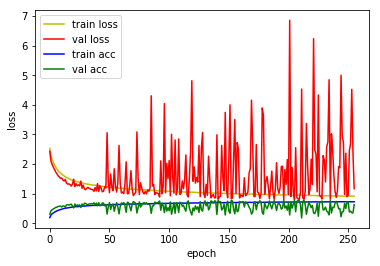

4815/4815 [==============================] - 3s 559us/sample - loss: 0.8655 - acc: 0.7367
Loss: 0.8654884642901078 Accuracy: 0.7366563

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4361 - acc: 0.2289
Epoch 00001: val_loss improved from inf to 2.26315, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_4_conv_checkpoint/001-2.2631.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.4361 - acc: 0.2289 - val_loss: 2.2631 - val_acc: 0.3317
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0735 - acc: 0.3422
Epoch 00002: val_loss improved from 2.26315 to 1.81012, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_4_conv_checkpoint/002-1.8101.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.0735 - acc: 0.3422 - val_loss: 1.8101 - val_acc: 0.5297
Epoch 3/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 1.0663 - acc: 0.6760
Epoch 00023: val_loss did not improve from 0.89565
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0663 - acc: 0.6759 - val_loss: 0.9130 - val_acc: 0.7477
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0542 - acc: 0.6805
Epoch 00024: val_loss improved from 0.89565 to 0.87672, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_4_conv_checkpoint/024-0.8767.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.0543 - acc: 0.6805 - val_loss: 0.8767 - val_acc: 0.7536
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0414 - acc: 0.6843
Epoch 00025: val_loss did not improve from 0.87672
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0414 - acc: 0.6843 - val_loss: 0.9385 - val_acc: 0.7328
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.035

36800/36805 [============================>.] - ETA: 0s - loss: 0.8791 - acc: 0.7357
Epoch 00050: val_loss did not improve from 0.69420
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8790 - acc: 0.7358 - val_loss: 0.7236 - val_acc: 0.7941
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8672 - acc: 0.7412
Epoch 00051: val_loss did not improve from 0.69420
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.8672 - acc: 0.7412 - val_loss: 0.7430 - val_acc: 0.7834
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8724 - acc: 0.7360
Epoch 00052: val_loss did not improve from 0.69420
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.8723 - acc: 0.7361 - val_loss: 0.9882 - val_acc: 0.6767
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8685 - acc: 0.7411
Epoch 00053: val_loss did not improve from 0.69420
36805/36805 [========================

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7876 - acc: 0.7637
Epoch 00079: val_loss did not improve from 0.63247
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7876 - acc: 0.7637 - val_loss: 0.8155 - val_acc: 0.7543
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7848 - acc: 0.7640
Epoch 00080: val_loss did not improve from 0.63247
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7848 - acc: 0.7640 - val_loss: 0.6350 - val_acc: 0.8321
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7780 - acc: 0.7689
Epoch 00081: val_loss did not improve from 0.63247
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7780 - acc: 0.7688 - val_loss: 0.6661 - val_acc: 0.8213
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7748 - acc: 0.7681
Epoch 00082: val_loss did not improve from 0.63247
36805/36805 [===========

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7250 - acc: 0.7839
Epoch 00108: val_loss did not improve from 0.58309
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7251 - acc: 0.7839 - val_loss: 0.6139 - val_acc: 0.8341
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7201 - acc: 0.7857
Epoch 00109: val_loss did not improve from 0.58309
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.7200 - acc: 0.7857 - val_loss: 0.9108 - val_acc: 0.7216
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7120 - acc: 0.7873
Epoch 00110: val_loss improved from 0.58309 to 0.58132, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_4_conv_checkpoint/110-0.5813.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7121 - acc: 0.7872 - val_loss: 0.5813 - val_acc: 0.8435
Epoch 111/500
36800/36805 [============================>.] - ETA:

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6830 - acc: 0.7970
Epoch 00137: val_loss did not improve from 0.56652
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6831 - acc: 0.7970 - val_loss: 0.7859 - val_acc: 0.7547
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6793 - acc: 0.7981
Epoch 00138: val_loss improved from 0.56652 to 0.55344, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_4_conv_checkpoint/138-0.5534.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6794 - acc: 0.7980 - val_loss: 0.5534 - val_acc: 0.8579
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.7988
Epoch 00139: val_loss did not improve from 0.55344
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6710 - acc: 0.7988 - val_loss: 0.6589 - val_acc: 0.8123
Epoch 140/500
36800/36805 [============================>.] - ETA:

Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6504 - acc: 0.8057
Epoch 00166: val_loss did not improve from 0.52271
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6503 - acc: 0.8057 - val_loss: 1.6535 - val_acc: 0.5723
Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6503 - acc: 0.8063
Epoch 00167: val_loss did not improve from 0.52271
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6503 - acc: 0.8063 - val_loss: 0.8006 - val_acc: 0.7570
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6432 - acc: 0.8081
Epoch 00168: val_loss did not improve from 0.52271
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6433 - acc: 0.8081 - val_loss: 5.4309 - val_acc: 0.3261
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6424 - acc: 0.8076
Epoch 00169: val_loss did not improve from 0.52271
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.6189 - acc: 0.8149
Epoch 00195: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6189 - acc: 0.8149 - val_loss: 2.4455 - val_acc: 0.4596
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6215 - acc: 0.8143
Epoch 00196: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6215 - acc: 0.8143 - val_loss: 0.5478 - val_acc: 0.8579
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6179 - acc: 0.8183
Epoch 00197: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.6180 - acc: 0.8183 - val_loss: 1.4832 - val_acc: 0.6222
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6200 - acc: 0.8164
Epoch 00198: val_loss did not improve from 0.50648
36805/36805 [=====================

Epoch 225/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5912 - acc: 0.8233
Epoch 00225: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5913 - acc: 0.8233 - val_loss: 1.4705 - val_acc: 0.6075
Epoch 226/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5965 - acc: 0.8212
Epoch 00226: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5965 - acc: 0.8211 - val_loss: 0.6317 - val_acc: 0.8195
Epoch 227/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.8231
Epoch 00227: val_loss did not improve from 0.50648
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5921 - acc: 0.8231 - val_loss: 2.0851 - val_acc: 0.5872
Epoch 228/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5876 - acc: 0.8230
Epoch 00228: val_loss did not improve from 0.50648
36805/36805 [=======

Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5703 - acc: 0.8271
Epoch 00254: val_loss did not improve from 0.49062
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5702 - acc: 0.8271 - val_loss: 1.3826 - val_acc: 0.6024
Epoch 255/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5669 - acc: 0.8304
Epoch 00255: val_loss did not improve from 0.49062
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5668 - acc: 0.8304 - val_loss: 2.0919 - val_acc: 0.5099
Epoch 256/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5691 - acc: 0.8300
Epoch 00256: val_loss did not improve from 0.49062
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5691 - acc: 0.8300 - val_loss: 2.0212 - val_acc: 0.5257
Epoch 257/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5734 - acc: 0.8284
Epoch 00257: val_loss did not improve from 0.49062
36805/36805 [=======

Epoch 284/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5562 - acc: 0.8314
Epoch 00284: val_loss did not improve from 0.49062
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5563 - acc: 0.8314 - val_loss: 0.5038 - val_acc: 0.8668
Epoch 285/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5574 - acc: 0.8338
Epoch 00285: val_loss did not improve from 0.49062
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5574 - acc: 0.8338 - val_loss: 0.6877 - val_acc: 0.7957
Epoch 286/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5533 - acc: 0.8329
Epoch 00286: val_loss did not improve from 0.49062
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5534 - acc: 0.8329 - val_loss: 0.4944 - val_acc: 0.8700
Epoch 287/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5556 - acc: 0.8332
Epoch 00287: val_loss did not improve from 0.49062
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.5376 - acc: 0.8365
Epoch 00313: val_loss did not improve from 0.47692
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5378 - acc: 0.8365 - val_loss: 0.4787 - val_acc: 0.8737
Epoch 314/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5416 - acc: 0.8374
Epoch 00314: val_loss did not improve from 0.47692
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5416 - acc: 0.8374 - val_loss: 0.5427 - val_acc: 0.8612
Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5354 - acc: 0.8381
Epoch 00315: val_loss did not improve from 0.47692
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5355 - acc: 0.8381 - val_loss: 2.7656 - val_acc: 0.4857
Epoch 316/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5314 - acc: 0.8407
Epoch 00316: val_loss did not improve from 0.47692
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5232 - acc: 0.8421
Epoch 00342: val_loss did not improve from 0.46854
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5234 - acc: 0.8421 - val_loss: 2.0162 - val_acc: 0.5302
Epoch 343/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5241 - acc: 0.8421
Epoch 00343: val_loss did not improve from 0.46854
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5242 - acc: 0.8421 - val_loss: 0.5782 - val_acc: 0.8337
Epoch 344/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5180 - acc: 0.8456
Epoch 00344: val_loss did not improve from 0.46854
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5180 - acc: 0.8456 - val_loss: 0.9319 - val_acc: 0.7032
Epoch 345/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5158 - acc: 0.8451
Epoch 00345: val_loss did not improve from 0.46854
36805/36805 [=====================

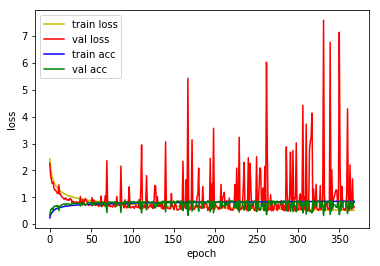

4815/4815 [==============================] - 3s 598us/sample - loss: 0.5369 - acc: 0.8451
Loss: 0.536925614486726 Accuracy: 0.8450675

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2068 - acc: 0.2992
Epoch 00001: val_loss improved from inf to 1.96978, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/001-1.9698.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.2068 - acc: 0.2992 - val_loss: 1.9698 - val_acc: 0.4160
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7189 - acc: 0.4602
Epoch 00002: val_loss improved from 1.96978 to 1.39162, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/002-1.3916.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.7189 - acc: 0.4602 - val_loss: 1.3916 - val_acc: 0.6271
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.6793 - acc: 0.8034
Epoch 00025: val_loss improved from 0.61209 to 0.55747, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/025-0.5575.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6795 - acc: 0.8034 - val_loss: 0.5575 - val_acc: 0.8553
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6668 - acc: 0.8064
Epoch 00026: val_loss did not improve from 0.55747
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6669 - acc: 0.8064 - val_loss: 0.5836 - val_acc: 0.8479
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6564 - acc: 0.8090
Epoch 00027: val_loss did not improve from 0.55747
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6564 - acc: 0.8090 - val_loss: 0.6725 - val_acc: 0.7992
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.648

36800/36805 [============================>.] - ETA: 0s - loss: 0.4827 - acc: 0.8598
Epoch 00052: val_loss improved from 0.43679 to 0.40915, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/052-0.4091.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.4827 - acc: 0.8598 - val_loss: 0.4091 - val_acc: 0.8915
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4805 - acc: 0.8605
Epoch 00053: val_loss improved from 0.40915 to 0.39432, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/053-0.3943.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.4805 - acc: 0.8605 - val_loss: 0.3943 - val_acc: 0.8959
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4764 - acc: 0.8621
Epoch 00054: val_loss did not improve from 0.39432
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.4764 - acc: 0.8621 - val_loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.3787 - acc: 0.8896
Epoch 00080: val_loss did not improve from 0.37235
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3788 - acc: 0.8895 - val_loss: 0.3820 - val_acc: 0.8994
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3697 - acc: 0.8929
Epoch 00081: val_loss improved from 0.37235 to 0.37118, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/081-0.3712.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3697 - acc: 0.8928 - val_loss: 0.3712 - val_acc: 0.9024
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3728 - acc: 0.8902
Epoch 00082: val_loss improved from 0.37118 to 0.36008, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_5_conv_checkpoint/082-0.3601.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3727 - acc: 0.8902 - val_loss: 0.

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3107 - acc: 0.9089
Epoch 00108: val_loss did not improve from 0.31962
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3107 - acc: 0.9089 - val_loss: 0.3386 - val_acc: 0.9115
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3093 - acc: 0.9099
Epoch 00109: val_loss did not improve from 0.31962
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3093 - acc: 0.9099 - val_loss: 0.3817 - val_acc: 0.8959
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3110 - acc: 0.9089
Epoch 00110: val_loss did not improve from 0.31962
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3109 - acc: 0.9089 - val_loss: 0.3640 - val_acc: 0.9066
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2978 - acc: 0.9120
Epoch 00111: val_loss did not improve from 0.31962
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2753 - acc: 0.9169
Epoch 00137: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2753 - acc: 0.9169 - val_loss: 0.3605 - val_acc: 0.9059
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2636 - acc: 0.9210
Epoch 00138: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2637 - acc: 0.9210 - val_loss: 0.3247 - val_acc: 0.9180
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2628 - acc: 0.9223
Epoch 00139: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2628 - acc: 0.9223 - val_loss: 0.3171 - val_acc: 0.9224
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2607 - acc: 0.9222
Epoch 00140: val_loss did not improve from 0.31342
36805/36805 [=====================

Epoch 167/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2261 - acc: 0.9324
Epoch 00167: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2261 - acc: 0.9324 - val_loss: 0.3262 - val_acc: 0.9178
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9337
Epoch 00168: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2201 - acc: 0.9337 - val_loss: 0.3239 - val_acc: 0.9187
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2269 - acc: 0.9308
Epoch 00169: val_loss did not improve from 0.31342
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2269 - acc: 0.9308 - val_loss: 0.3156 - val_acc: 0.9194
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2190 - acc: 0.9354
Epoch 00170: val_loss did not improve from 0.31342
36805/36805 [=======

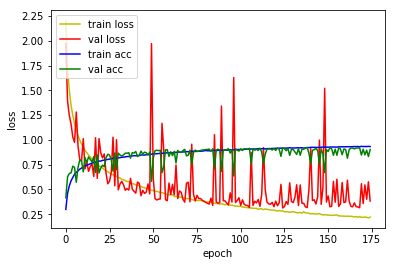

4815/4815 [==============================] - 3s 615us/sample - loss: 0.3902 - acc: 0.8874
Loss: 0.39020791636820523 Accuracy: 0.8874351

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9960 - acc: 0.3733
Epoch 00001: val_loss improved from inf to 1.73286, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_6_conv_checkpoint/001-1.7329.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.9960 - acc: 0.3733 - val_loss: 1.7329 - val_acc: 0.4936
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3813 - acc: 0.5874
Epoch 00002: val_loss improved from 1.73286 to 1.04779, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_6_conv_checkpoint/002-1.0478.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.3813 - acc: 0.5875 - val_loss: 1.0478 - val_acc: 0.7333
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3447 - acc: 0.9006
Epoch 00023: val_loss did not improve from 0.27564
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3448 - acc: 0.9006 - val_loss: 0.3009 - val_acc: 0.9173
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3344 - acc: 0.9030
Epoch 00024: val_loss did not improve from 0.27564
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3346 - acc: 0.9029 - val_loss: 0.2902 - val_acc: 0.9243
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3222 - acc: 0.9075
Epoch 00025: val_loss improved from 0.27564 to 0.26436, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_6_conv_checkpoint/025-0.2644.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.3224 - acc: 0.9075 - val_loss: 0.2644 - val_acc: 0.9259
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9403
Epoch 00050: val_loss did not improve from 0.21899
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1999 - acc: 0.9403 - val_loss: 0.2287 - val_acc: 0.9369
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9411
Epoch 00051: val_loss did not improve from 0.21899
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1983 - acc: 0.9411 - val_loss: 0.2269 - val_acc: 0.9418
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1931 - acc: 0.9433
Epoch 00052: val_loss improved from 0.21899 to 0.21022, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_6_conv_checkpoint/052-0.2102.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1932 - acc: 0.9433 - val_loss: 0.2102 - val_acc: 0.9443
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.189

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1321 - acc: 0.9603
Epoch 00079: val_loss did not improve from 0.19980
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1324 - acc: 0.9602 - val_loss: 0.2108 - val_acc: 0.9413
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1352 - acc: 0.9584
Epoch 00080: val_loss did not improve from 0.19980
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1353 - acc: 0.9584 - val_loss: 0.2437 - val_acc: 0.9317
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9599
Epoch 00081: val_loss did not improve from 0.19980
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1325 - acc: 0.9598 - val_loss: 0.2249 - val_acc: 0.9434
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1294 - acc: 0.9610
Epoch 00082: val_loss did not improve from 0.19980
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9730
Epoch 00108: val_loss improved from 0.19425 to 0.18820, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_6_conv_checkpoint/108-0.1882.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0916 - acc: 0.9730 - val_loss: 0.1882 - val_acc: 0.9476
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9732
Epoch 00109: val_loss did not improve from 0.18820
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0892 - acc: 0.9732 - val_loss: 0.1966 - val_acc: 0.9460
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9746
Epoch 00110: val_loss did not improve from 0.18820
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0845 - acc: 0.9746 - val_loss: 0.2533 - val_acc: 0.9348
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9806
Epoch 00137: val_loss did not improve from 0.18820
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0653 - acc: 0.9806 - val_loss: 0.2243 - val_acc: 0.9441
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9804
Epoch 00138: val_loss did not improve from 0.18820
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0673 - acc: 0.9803 - val_loss: 0.2007 - val_acc: 0.9506
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9809
Epoch 00139: val_loss did not improve from 0.18820
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0653 - acc: 0.9809 - val_loss: 0.2059 - val_acc: 0.9522
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9811
Epoch 00140: val_loss did not improve from 0.18820
36805/36805 [=====================

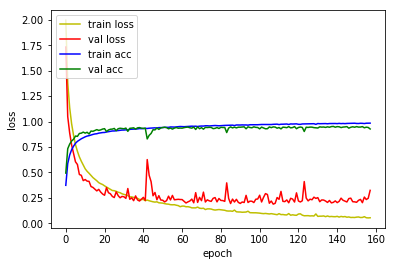

4815/4815 [==============================] - 3s 673us/sample - loss: 0.2353 - acc: 0.9350
Loss: 0.23532529091414137 Accuracy: 0.9349948

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7952 - acc: 0.4438
Epoch 00001: val_loss improved from inf to 1.39866, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_7_conv_checkpoint/001-1.3987.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.7952 - acc: 0.4438 - val_loss: 1.3987 - val_acc: 0.6175
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9922 - acc: 0.7145
Epoch 00002: val_loss improved from 1.39866 to 0.64716, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_7_conv_checkpoint/002-0.6472.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.9924 - acc: 0.7145 - val_loss: 0.6472 - val_acc: 0.8505
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.1411 - acc: 0.9593
Epoch 00025: val_loss did not improve from 0.14488
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1411 - acc: 0.9593 - val_loss: 0.1959 - val_acc: 0.9453
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1352 - acc: 0.9602
Epoch 00026: val_loss did not improve from 0.14488
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1352 - acc: 0.9602 - val_loss: 0.1888 - val_acc: 0.9476
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1297 - acc: 0.9618
Epoch 00027: val_loss did not improve from 0.14488
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1298 - acc: 0.9618 - val_loss: 0.1613 - val_acc: 0.9509
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9625
Epoch 00028: val_loss did not improve from 0.14488
36805/36805 [========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9830
Epoch 00054: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0568 - acc: 0.9830 - val_loss: 0.1430 - val_acc: 0.9609
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9855
Epoch 00055: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0497 - acc: 0.9855 - val_loss: 0.1443 - val_acc: 0.9599
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9849
Epoch 00056: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0498 - acc: 0.9849 - val_loss: 0.2107 - val_acc: 0.9411
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0523 - acc: 0.9852
Epoch 00057: val_loss did not improve from 0.14011
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9913
Epoch 00084: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0298 - acc: 0.9913 - val_loss: 0.1919 - val_acc: 0.9555
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9927
Epoch 00085: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0270 - acc: 0.9927 - val_loss: 0.1670 - val_acc: 0.9632
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9935
Epoch 00086: val_loss did not improve from 0.14011
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0246 - acc: 0.9935 - val_loss: 0.1825 - val_acc: 0.9581
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9925
Epoch 00087: val_loss did not improve from 0.14011
36805/36805 [===========

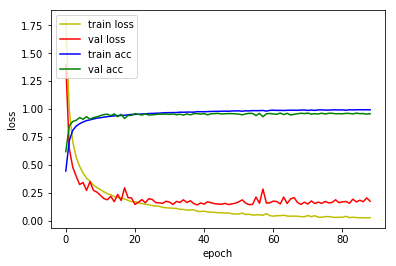

4815/4815 [==============================] - 3s 660us/sample - loss: 0.1713 - acc: 0.9489
Loss: 0.17125582505609388 Accuracy: 0.94890964

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6859 - acc: 0.4783
Epoch 00001: val_loss improved from inf to 1.00839, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_8_conv_checkpoint/001-1.0084.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.6858 - acc: 0.4784 - val_loss: 1.0084 - val_acc: 0.7421
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7639 - acc: 0.7734
Epoch 00002: val_loss improved from 1.00839 to 0.41513, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_DO_BN_8_conv_checkpoint/002-0.4151.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.7639 - acc: 0.7734 - val_loss: 0.4151 - val_acc: 0.8919
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9788
Epoch 00025: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0733 - acc: 0.9788 - val_loss: 0.1524 - val_acc: 0.9553
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9755
Epoch 00026: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0820 - acc: 0.9755 - val_loss: 0.1366 - val_acc: 0.9627
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9808
Epoch 00027: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0648 - acc: 0.9808 - val_loss: 0.1352 - val_acc: 0.9578
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9804
Epoch 00028: val_loss did not improve from 0.12061
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9943
Epoch 00055: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0203 - acc: 0.9943 - val_loss: 0.1747 - val_acc: 0.9574
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9931
Epoch 00056: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0234 - acc: 0.9931 - val_loss: 0.1708 - val_acc: 0.9597
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9897
Epoch 00057: val_loss did not improve from 0.12061
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0339 - acc: 0.9897 - val_loss: 0.1397 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9962
Epoch 00058: val_loss did not improve from 0.12061
36805/36805 [===========

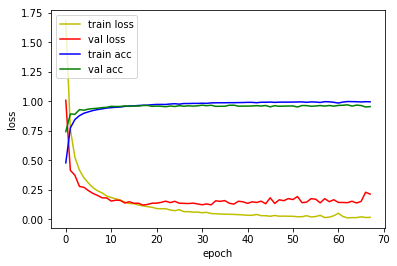

4815/4815 [==============================] - 3s 702us/sample - loss: 0.1721 - acc: 0.9508
Loss: 0.17213183499694737 Accuracy: 0.95077884



In [10]:
base = '1D_CNN_custom_multi_3_GAP_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 3s 674us/sample - loss: 0.5369 - acc: 0.8451
Loss: 0.536925614486726 Accuracy: 0.8450675

1D_CNN_custom_multi_3_GAP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)  

4815/4815 [==============================] - 4s 744us/sample - loss: 0.2353 - acc: 0.9350
Loss: 0.23532529091414137 Accuracy: 0.9349948

1D_CNN_custom_multi_3_GAP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 4s 781us/sample - loss: 0.1721 - acc: 0.9508
Loss: 0.17213183499694737 Accuracy: 0.95077884


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 780us/sample - loss: 0.7202 - acc: 0.7796
Loss: 0.7201832166713347 Accuracy: 0.77964693

1D_CNN_custom_multi_3_GAP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)

4815/4815 [==============================] - 4s 825us/sample - loss: 0.3673 - acc: 0.9080
Loss: 0.36726190790085284 Accuracy: 0.9079958

1D_CNN_custom_multi_3_GAP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 4s 896us/sample - loss: 0.2710 - acc: 0.9379
Loss: 0.2710006074556309 Accuracy: 0.9379024
